In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.ticker import NullFormatter
from scipy import linalg as la
plt.rcParams['font.size'] = 12

# manifold.TSNE
from sklearn import manifold  #, datasets
from time import time

from sklearn.neighbors import NearestNeighbors

## Data and labels 
In this example we know the labels, hence we can test the performances of t-SNE and DBSCAN

In [4]:
fname,fnamey="x_12d.dat","y_12d.dat"
data=np.loadtxt("DATA/"+fname, delimiter='\t')
y=np.loadtxt("DATA/"+fnamey,dtype=int)
N=len(data)
D=len(data[0])
print("N=",N,"  L=D=",D)
x=data

N= 600   L=D= 12


## Find the typical minimum distance between points
This yields a typical scale, to be used as a reference for "eps"

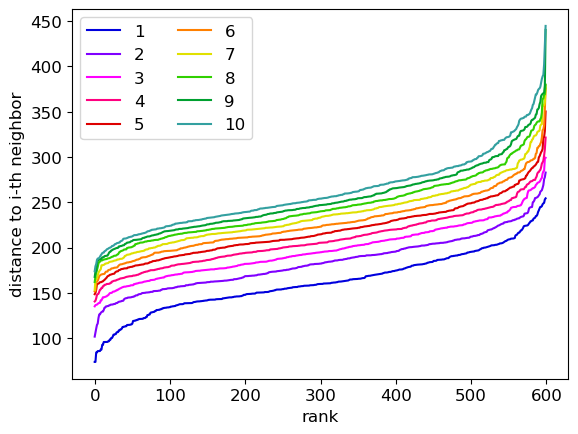

mean minimum distance between points:  162.34622464324366


In [6]:
nn = 10
nbrs = NearestNeighbors(n_neighbors=nn+1).fit(x) #, algorithm='ball_tree'
d, ind = nbrs.kneighbors(x)
dd=d.T
# note: dd[0] has a trivial set of zeros
listc= ["#0000DD","#8000FF","#FF00FF","#FF0080","#DD0000",
        "#FF8000","#E0E000","#30D000","#00A030","#33A0A0"]
for i in range(1,nn+1):
    plt.plot(np.sort(dd[i]),c=listc[i-1],label=str(i))
    plt.xlabel("rank")
    plt.ylabel("distance to i-th neighbor")
plt.legend(ncol=2)
plt.show()
mean_min_dist = np.mean(dd[1])
print("mean minimum distance between points: ",mean_min_dist)

## t-SNE visualization, for true labels

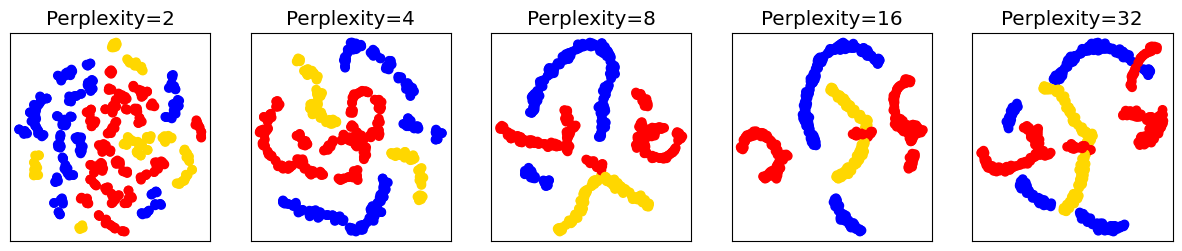

In [8]:
np.random.seed(0)
n_samples = N
n_components = 2 
perplexities = [2, 4, 8, 16, 32]
Np = len(perplexities)
mycmap = ListedColormap(["blue","red","gold" ])

(fig, subplots) = plt.subplots(1,Np , figsize=(3*Np, 2.7))

X_all = [None]
for i, perplexity in enumerate(perplexities):
    ax = subplots[i]

    t0 = time()
    tsne = manifold.TSNE(n_components=n_components, init='random',
                         random_state=0, perplexity=perplexity)
    Y = tsne.fit_transform(data)
    t1 = time()
    ax.set_title("Perplexity=%d" % perplexity)
    ax.scatter(Y[:, 0], Y[:, 1], c=y,cmap=mycmap)
    ax.tick_params(left=False,bottom=False)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')
    X_all.append(Y)
    
plt.show()

## Different random initial states (random_state=i)

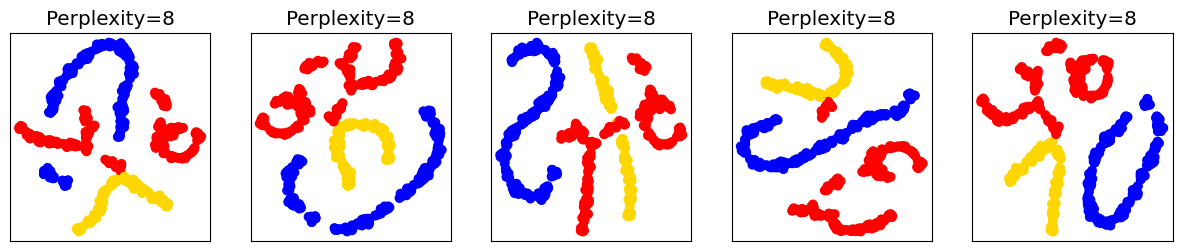

In [10]:
n_samples = N
n_components = 2 
mycmap = ListedColormap(["blue","red","gold"])

(fig, subplots) = plt.subplots(1,Np , figsize=(3*Np, 2.7))

X_all = [None]

perplexity= 8

for i in range(5):
    np.random.seed(i) 
    ax = subplots[i]

    t0 = time()
    tsne = manifold.TSNE(n_components=n_components, 
                         init='random',random_state=i, 
                         perplexity=perplexity)
    Y = tsne.fit_transform(data)
    t1 = time()
    ax.set_title("Perplexity=%d" % perplexity)
    ax.scatter(Y[:, 0], Y[:, 1], c=y,cmap=mycmap)
    ax.tick_params(left=False,bottom=False)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')
    X_all.append(Y)
    
plt.show()

## DBSCAN: find labels by applying clustering

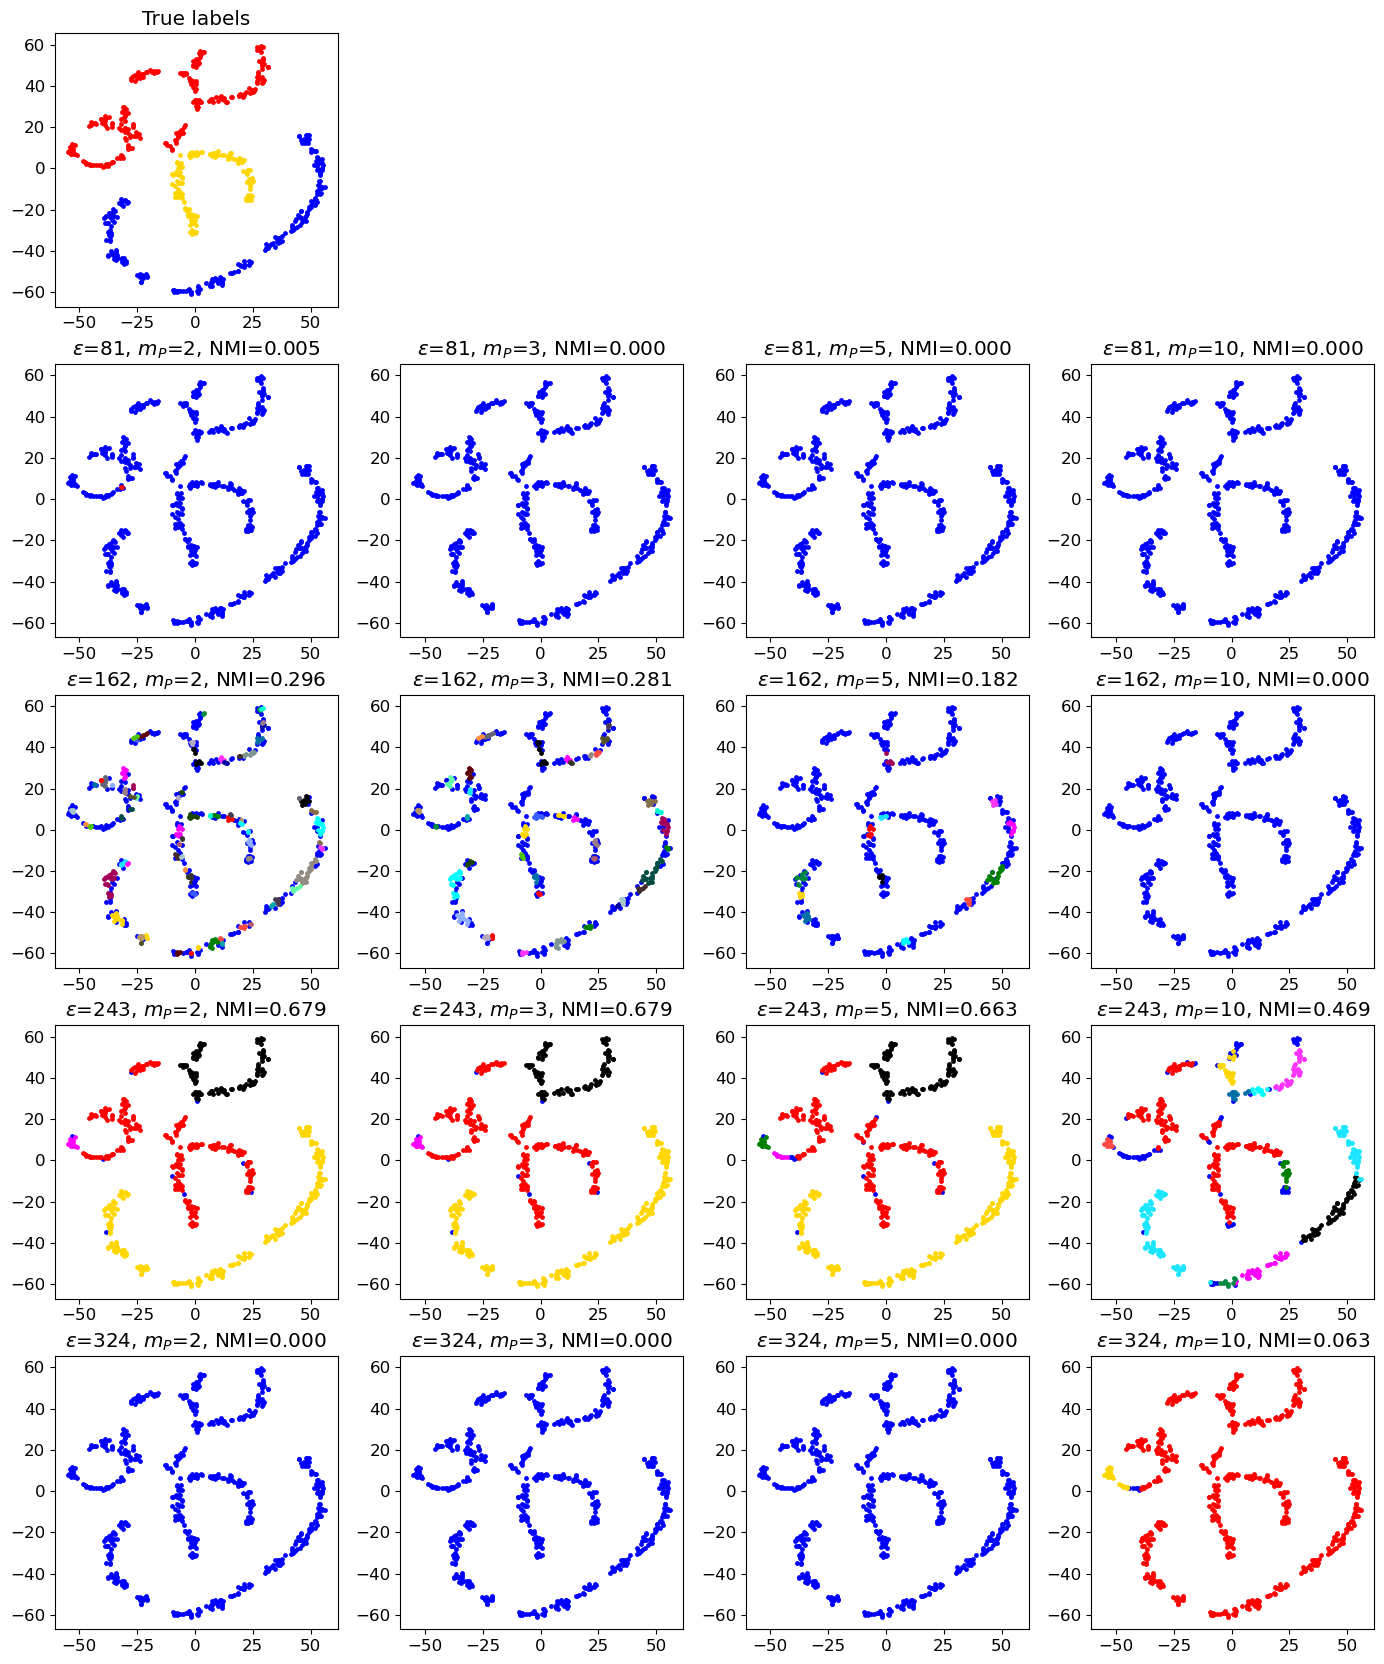

In [12]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
cpalette = ["blue","red","gold","black","magenta","green","cyan","#1CE6FF", "#FF34FF", "#FF4A46","#008941", "#006FA6", "#A30059", "#0000A6", "#63FFAC","#B79762", "#004D43", "#8FB0FF", "#997D87","#5A0007", "#809693","#1B4400", "#4FC601", "#3B5DFF", "#4A3B53","#886F4C","#34362D", "#B4A8BD", "#00A6AA", "#452C2C","#636375", "#A3C8C9", "#FF913F", "#938A81","#575329", "#00FECF", "#B05B6F"]
from collections import OrderedDict
ms = 6

def clustering(y):
    # Finds position of labels and returns a dictionary of cluster labels to data indices.
    yu = np.sort(np.unique(y))
    clustering = OrderedDict()
    for ye in yu:
        clustering[ye] = np.where(y == ye)[0]
    return clustering

def entropy(c, n_sample):
    # Measures the entropy of a cluster
    h = 0.
    for kc in c.keys():
        p=len(c[kc])/n_sample
        h+=p*np.log(p)
    h*=-1.
    return h

# Normalized mutual information function
# Note that this deals with the label permutation problem
def NMI(y_true, y_pred):
    """ Computes normalized mutual information: where y_true and y_pred are both clustering assignments
    """
    w = clustering(y_true)
    c = clustering(y_pred)
    n_sample = len(y_true)

    Iwc = 0.
    for kw in w.keys():
        for kc in c.keys():
            w_intersect_c=len(set(w[kw]).intersection(set(c[kc])))
            if w_intersect_c > 0:
                Iwc += w_intersect_c*np.log(n_sample*w_intersect_c/(len(w[kw])*len(c[kc])))
    Iwc/=n_sample
    Hc = entropy(c,n_sample)
    Hw = entropy(w,n_sample)

    return 2*Iwc/(Hc+Hw)

def plotting_ax(X, y, ax):
    # plotting function
    for i, yu in enumerate(np.unique(y)):
        pos = (y == yu)
        ax.scatter(X[pos,0], X[pos,1],c=cpalette[i%len(cpalette)],s=ms)

# DBSCAN has a few parameters, let's sweep over a few parameters and see what happens
np.random.seed(12345)
n_true_center=3
#X, ytrue = make_blobs(10000, 2, n_true_center) # Generating random gaussian mixture
X2D = X_all[2] # best(?) visualization above
X = data
y_true = y

#eps_range = [0.01,0.1,0.5,1.0,10.]
if mean_min_dist<10:
    r=mean_min_dist
else:
    r = int(mean_min_dist)
eps_range = [r/2,r,1.5*r,2*r]

min_sample_range = [2,3,5,10]
DIMY=len(eps_range)
DIMX=len(min_sample_range)
fig, ax = plt.subplots(DIMY+1,DIMX,figsize=(14,16.8))

i,j=0,0
nmi=1
plotting_ax(X2D,y,ax[i,j])
ax[i,j].set_title('True labels')
for j in range(1,DIMX): fig.delaxes(ax[i,j])
    
for i, eps in enumerate(eps_range):
    for j, min_samples in enumerate(min_sample_range):
        model = DBSCAN(eps=eps, min_samples=min_samples)
        model.fit(X)
        y_hat = model.labels_
        plotting_ax(X2D,y_hat,ax[i+1,j])
        nmi=NMI(y_hat, y_true)
        ax[i+1,j].set_title(r'$\epsilon$=%.0f, $m_P$=%i, NMI=%.3f'%(eps,min_samples,nmi))

plt.tight_layout(h_pad=0.5)
plt.show()


## PCA: Principal Component Analysis

In [14]:
# transpose data matrix
dataT = data.T
# find eigenvalues and eigenvectors of covariance matrix and sort them by principal component
U, spectrum, Vt = la.svd(dataT)
l = spectrum**2 / (data.shape[1] - 1)

Lambda = np.real_if_close(np.diag(l))

princ_comp = []

for i in range(Lambda.shape[0]):
    princ_comp.append(Lambda[i, i]/Lambda.trace())
    print(f'variability using up to PC {i+1}: {np.round(np.cumsum(princ_comp)[i] * 100, 1)} %')

variability using up to PC 1: 56.1 %
variability using up to PC 2: 86.4 %
variability using up to PC 3: 96.4 %
variability using up to PC 4: 96.9 %
variability using up to PC 5: 97.3 %
variability using up to PC 6: 97.8 %
variability using up to PC 7: 98.2 %
variability using up to PC 8: 98.6 %
variability using up to PC 9: 99.0 %
variability using up to PC 10: 99.3 %
variability using up to PC 11: 99.7 %
variability using up to PC 12: 100.0 %


The first three principal components capture 96% of the data's variability. We then project the data onto this reduced basis to retain most of its information while simplifying its representation.

In [16]:
rotated_data = np.dot(U, dataT)

rotated_data_0 = rotated_data.T[y_true == 0]
rotated_data_1 = rotated_data.T[y_true.T == 1]
rotated_data_2 = rotated_data.T[y_true.T == 2]

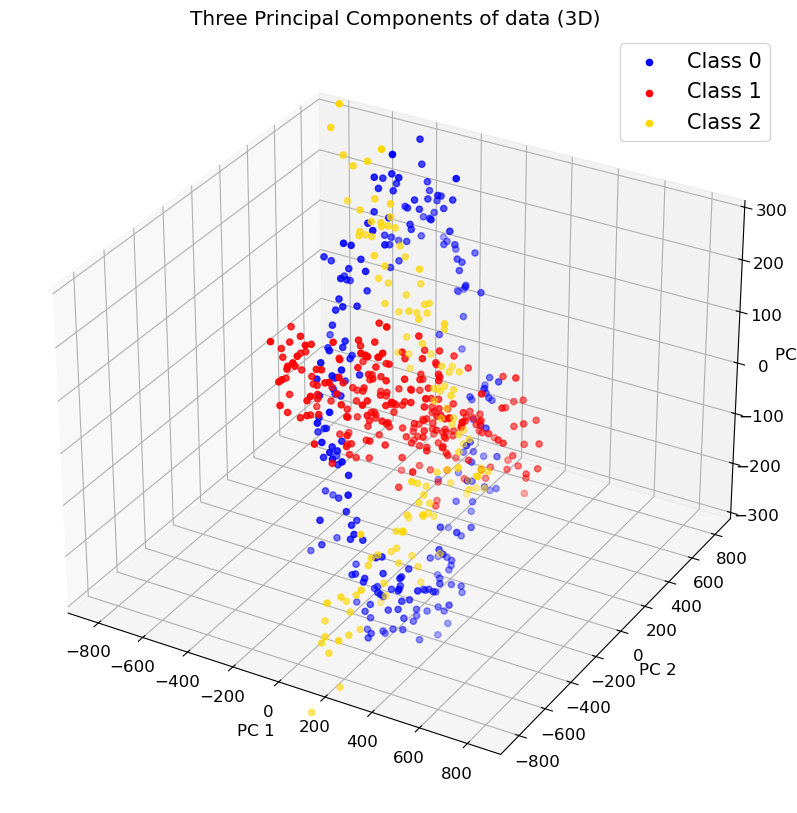

In [22]:
# plot the first three principal component rotated data
scale_factor = 0.005

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
ax.scatter3D(rotated_data_0[:,0], rotated_data_0[:,1], rotated_data_0[:,2], label='Class 0', c='blue')
ax.scatter3D(rotated_data_1[:,0], rotated_data_1[:,1], rotated_data_1[:,2], label='Class 1', c='red')
ax.scatter3D(rotated_data_2[:,0], rotated_data_2[:,1], rotated_data_2[:,2], label='Class 2', c='gold')
ax.set_xlim(-900,900)
ax.set_ylim(-900,900)
ax.set_zlim(-300,300)
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')
ax.legend(fontsize=15)
plt.title('Three Principal Components of data (3D)')
plt.show()

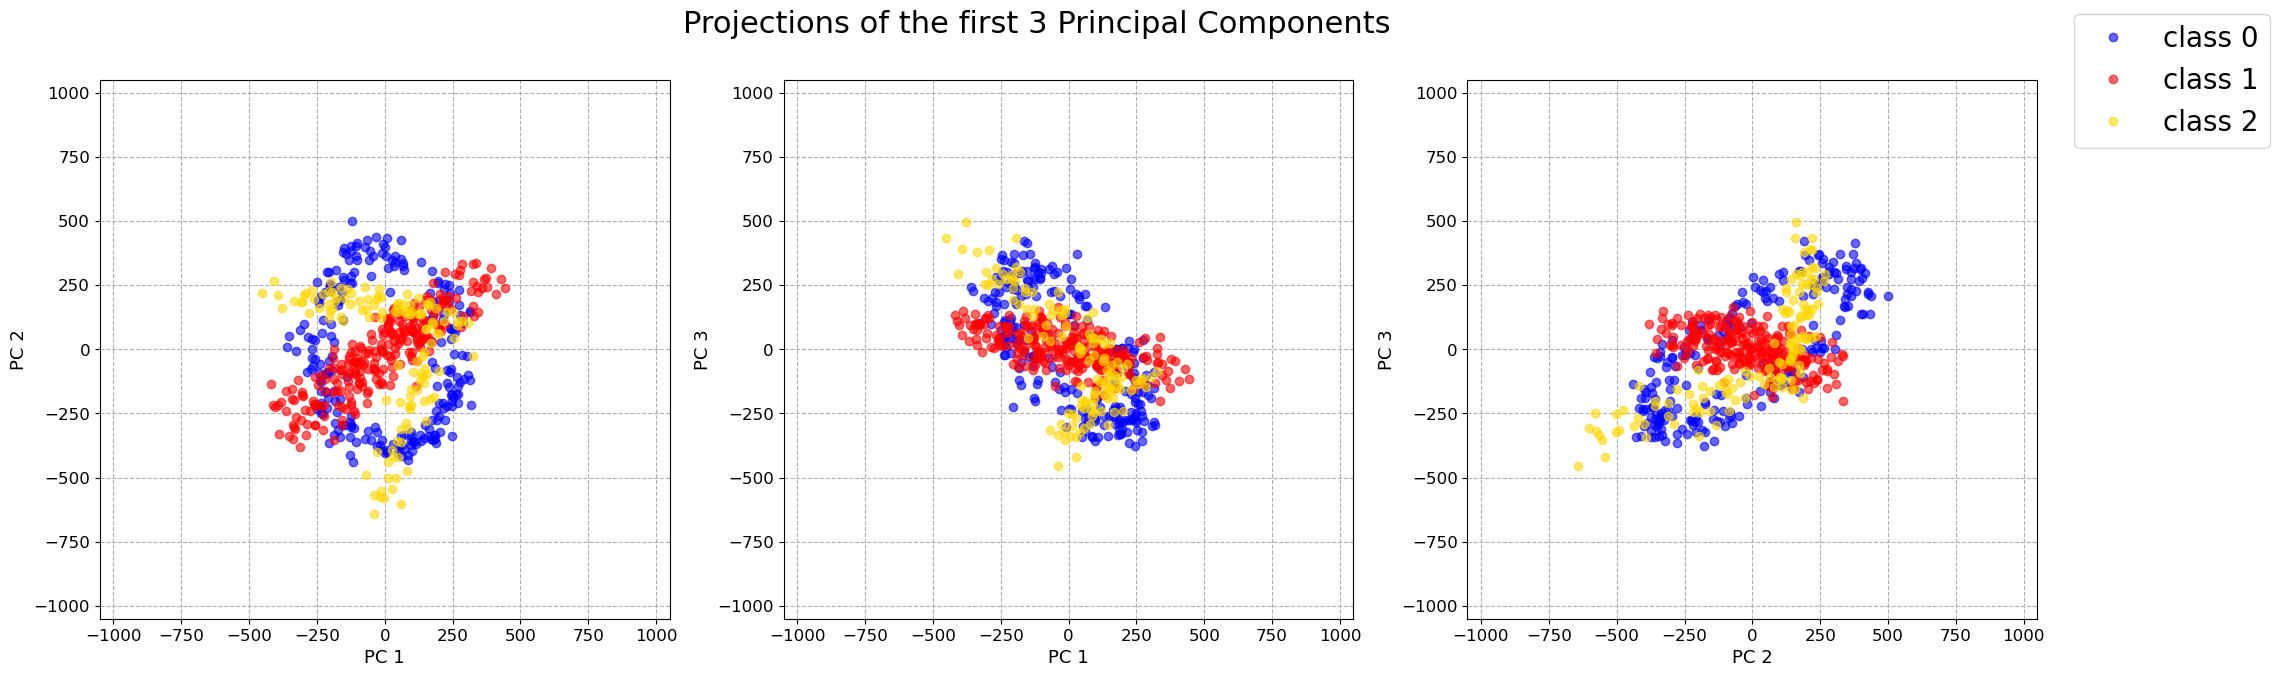

In [20]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (25, 7))

maxlim = 1050

ax[0].plot(rotated_data_0[:, 0], rotated_data_0[:, 1], 'o', alpha = .6, label = 'class 0', c='blue')
ax[0].plot(rotated_data_1[:, 0], rotated_data_1[:, 1], 'o', alpha = .6, label = 'class 1', c='red')
ax[0].plot(rotated_data_2[:, 0], rotated_data_2[:, 1], 'o', alpha = .6, label = 'class 2', c='gold')
ax[0].set_xlim(-maxlim, maxlim)
ax[0].set_ylim(-maxlim, maxlim)
ax[0].set_xlabel('PC 1', fontsize=13)
ax[0].set_ylabel('PC 2', fontsize=13)
ax[0].grid(True, linestyle='--')

ax[1].plot(rotated_data_0[:, 0], rotated_data_0[:, 2], 'o', alpha = .6, c = 'blue')
ax[1].plot(rotated_data_1[:, 0], rotated_data_1[:, 2], 'o', alpha = .6, c = 'red')
ax[1].plot(rotated_data_2[:, 0], rotated_data_2[:, 2], 'o', alpha = .6, c = 'gold')
ax[1].set_xlim(-maxlim, maxlim)
ax[1].set_ylim(-maxlim, maxlim)
ax[1].set_xlabel('PC 1', fontsize=13)
ax[1].set_ylabel('PC 3', fontsize=13)
ax[1].grid(True, linestyle='--')

ax[2].plot(rotated_data_0[:, 1], rotated_data_0[:, 2], 'o', alpha = .6, c = 'blue')
ax[2].plot(rotated_data_1[:, 1], rotated_data_1[:, 2], 'o', alpha = .6, c = 'red')
ax[2].plot(rotated_data_2[:, 1], rotated_data_2[:, 2], 'o', alpha = .6, c = 'gold')
ax[2].set_xlim(-maxlim, maxlim)
ax[2].set_ylim(-maxlim, maxlim)
ax[2].set_xlabel('PC 2', fontsize=13)
ax[2].set_ylabel('PC 3', fontsize=13)
ax[2].grid(True, linestyle='--')

fig.legend(fontsize=20)
fig.suptitle('Projections of the first 3 Principal Components', fontsize=22)
plt.show()

It can be seen from the first plot above that the dimensional reducted dataset up to the first 2 Principal Components still maintains its structure and 3 clusters are very recognizable.